In [8]:
import pylab
import h5py
import math
import array
from numpy import *
import numpy as np
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.waveform.waveform_modes import get_td_waveform_modes
from pycbc import types, fft, waveform
import lal
from scipy import interpolate
from scipy.interpolate import interp1d
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI, PI
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from tqdm import tqdm#


import matplotlib as mpl

 
from matplotlib import gridspec
from matplotlib import ticker

import matplotlib.pyplot as plt


In [9]:
# Eq. (4.17a, 4.17b), Pg. 18, Moore et al (2016)

def epsilon(xi, eta):
    return(( 1 + ( ( -2833/2016 + 197/72 * eta ) * ( xi )**( 2/3 ) + 
                  ( -377/144 * np.pi * xi + ( ( 77006005/24385536 + ( -1143767/145152 * eta + 
 	 43807/10368 * ( eta )**( 2 ) ) ) * ( xi )**( 4/3 ) + ( np.pi * ( 9901567/1451520 + 
 	 -202589/362880 * eta ) * ( xi )**( 5/3 ) + ( xi )**( 2 ) * ( -33320661414619/386266890240 + 
 	 ( 3317/252 * EulerGamma + ( 180721/41472 * ( np.pi )**( 2 ) + ( ( 161339510737/8778792960 + 
 	 3977/2304 * ( np.pi )**( 2 ) ) * eta + ( -359037739/20901888 * ( eta )**( 2 ) + 
      ( 10647791/2239488 * ( eta )**( 3 ) + ( -87419/3780 * np.log( 2 ) + 
 	 ( 26001/1120 * np.log( 3 ) + 3317/504 * np.log( 16 * ( xi )**( 2/3 ) ) ) ) ) ) ) ) ) ) ) ) ) ) ))

In [10]:
# "Hinder+ modified all 20 simulations SEOBNRv4 model, full frequency range --Feb 16
g=open('tshift_H+modified_20hyb_Feb16.txt',"r") 
lines=g.readlines() 
A=[] 
for x in lines: 
    A.append(float(x.split()[1])) 
g.close()

def tshift_Hinsp(q,e,l): 
    return A[0] + A[1]*q + A[2]*q**2 + A[3]*e + A[4]*e**2 + A[5]*e**3 + A[6]*e*q + A[7]*(e**2)*q + A[8]*e*(q**2) + A[9]*(e**2)*(q**2) + A[10]*(e**3)*q + A[11]*e*q*math.cos(l + A[12]) + A[13]*(e**2)*(q**2)*math.cos(e*l + A[14]) + A[15]*(e**3)*q*math.cos(l + A[16]) + A[17]*e*(q**2)*math.cos(l + A[18])

g=open('tamp_H+modified_20hyb_Feb16.txt',"r") 
lines=g.readlines() 
B=[] 
for x in lines: 
    B.append(float(x.split()[1])) 
g.close()

def tamp_Hinsp(eta,e,l): 
    return B[0] + B[1]*eta + B[2]*eta**2 + B[3]*e + B[4]*e**2 + B[5]*e**3 + B[6]*e*eta + B[7]*(e**2)*eta + B[8]*e*(eta**2) + B[9]*(e**2)*(eta**2) + B[10]*(e**3)*eta + B[11]*e*eta*math.cos(l + B[12]) + B[13]*(e**2)*(eta**2)*math.cos(l + B[14]) + B[15]*(e**3)*eta*math.cos(e*l + B[16])

g=open('tfreq_H+modified_20hyb_Feb16.txt',"r") 
lines=g.readlines() 
C=[] 
for x in lines: 
    C.append(float(x.split()[1])) 
g.close()

def tfreq_Hinsp(eta,e,l): 
    return C[0] + C[1]*eta + C[2]*eta**2 + C[3]*e + C[4]*e**2 + C[5]*e**3 + C[6]*e*eta + C[7]*(e**2)*eta + C[8]*e*(eta**2) + C[9]*(e**2)*(eta**2) + C[10]*(e**3)*eta + C[11]*e*eta*math.cos(l + C[12]) + C[13]*(e**2)*(eta**2)*math.cos(l + C[14]) + C[15]*(e**3)*eta*math.cos(e*l + C[16])+ C[17]*(e**3)*(eta**2)*math.cos(e*l + C[18])

In [11]:
def sph_harmonics(inc,ell):
    L=ell
    #inc = 10
    theta = inc
    for l in range(L,L+1):

        for m in range(-l,l+1):
            dlm = 0;
            k1 = max([0, m-2]);
            k2 = min([l+m, l-2]);

            #if(m==l or m==l-1):
            for k in range(k1,k2+1):
                A = []; B = []; cosTerm = []; sinTerm = []; dlmTmp = [];

                A = (-1)**k*math.sqrt(math.factorial(l+m)*math.factorial(l-m)*math.factorial(l+2)*math.factorial(l-2));
                B = math.factorial(k)*math.factorial(k-m+2)*math.factorial(l+m-k)*math.factorial(l-k-2);

                cosTerm = pow(math.cos(theta/2), 2*l+m-2*k-2);
                sinTerm = pow(math.sin(theta/2), 2*k-m+2);

                dlmTmp = (A/B)*cosTerm*sinTerm;
                dlm = dlm+dlmTmp

            Ylm = math.sqrt((2*l+1)/(4*math.pi))*dlm
            #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
            if m==ell:
                #globals()['sph' + str(l) + str(m)] = Ylm
                #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
                sphlm = Ylm
            elif m==-ell:
                #globals()['sph' + str(l) + '_' + str(abs(m))] = Ylm
                #print('l:',l,'m:',m,'\t Y_lm:',Ylm)
                sphl_m = Ylm
            else:
                continue
    return sphlm, sphl_m

In [12]:
def xi(x):
    return x**(3/2)

def xconv(f,M):
    return (PI*M*MTSUN_SI*f)**(2/3)  #22 mode conversion

def fconv(x,M):
    return x**(3/2)/(PI*M*MTSUN_SI)  #22 mode conversion


In [13]:
def eccmodel(Mass,q0,e0,l0,fmin,inclination=0,d=1,delta_t=1./4096,modes=[[2,2]]):
    
    #delta_t=0.00015208911520102518
    #delta_t = 1/2**20
    ell = []
    numrows = len(modes)
    numcols = len(modes[0])
    for i in range(0,numrows):
        l = modes[i][0]
        m = modes[i][1]
        ell.append(l)
    angle = inclination
    waveform = {}
    count = 0
    el = 2
    if el in ell:
        mode_data = {}
        mode_data['hp'], mode_data['hc'], mode_data['t'] = model_22(Mass,q0,e0,l0,fmin,angle,d,delta_t)
        waveform['l2_m2'] = mode_data
        count = count + 1

    el = 3
    if el in ell:
        mode_data = {}
        mode_data['hp'], mode_data['hc'], mode_data['t'] = MODEL33(Mass,q0,e0,l0,fmin,angle,d,delta_t)
        waveform['l3_m3'] = mode_data
        count = count + 1
        
    el = 4
    if el in ell:
        mode_data = {}
        mode_data['hp'], mode_data['hc'], mode_data['t'] = MODEL44(Mass,q0,e0,l0,fmin,angle,d,delta_t)
        waveform['l4_m4'] = mode_data
        count = count + 1
        
    el = 5
    if el in ell:
        mode_data = {}
        mode_data['hp'], mode_data['hc'], mode_data['t'] = MODEL55(Mass,q0,e0,l0,fmin,angle,d,delta_t)
        waveform['l5_m5'] = mode_data
        count = count + 1
        
    len_max_mode = '0'
    len_max = 0
    for mode in waveform.keys():
        if len(waveform[mode]['t'])>len_max:
            len_max_mode = mode
            len_max = len(waveform[mode]['t'])
            
    for mode in waveform.keys():
        if mode != len_max_mode:
            waveform[mode]['hp'].resize(len_max)
            waveform[mode]['hc'].resize(len_max)
            
    hp=0
    hc=0
    time=waveform[len_max_mode]['t']
    for mode in waveform.keys():
        hp = hp + waveform[mode]['hp']
        hc = hc + waveform[mode]['hc']
        
    hplus = TimeSeries(hp,delta_t,epoch=time[0])
    hcross = TimeSeries(hc,delta_t,epoch=time[0])
    
    return hplus, hcross

In [46]:
hfile =['1364hyb_EccTD_xlow045_GM.h5'] #['1167_EccTD_Ebersold_HM.h5']    
def model_22(m,q0,e0,l0,fmin,angle,d,delta_t):
    
    for i in range(0,len(hfile)):
        hyb_name = hfile[i][0:4]
        f = h5py.File(hfile[i],'r')
        data = f['l2_m2']
        tVec = real(data[0:,0])
        h22pVec = real(data[0:,1])
        h22cVec = real(data[0:,2])
        mode2polfac=4*(5/(64*np.pi))**(1/2)
        hpVec=h22pVec
        hcVec=h22cVec

        tVec = tVec - tVec[np.argmax(abs(hpVec + 1j*hcVec))]
        #print(Mtot[i])
        M=m
        q=q0
        M1 = q*M/(1+q)
        M2 = M/(1+q)
        eta = q/(1+q)**2

        M_SI=M*MSUN_SI
        D_SI=(10**(6))*PC_SI
        tVec=tVec*M*MTSUN_SI
        hpVec=hpVec*G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac
        hcVec=hcVec*G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac
    
    
        tVec = tVec - tVec[np.argmax(abs(hpVec + 1j*hcVec))]

        delta_t = delta_t_NR = np.abs(np.mean((np.diff(tVec))))

        fref = 0.075**(3/2) /MTSUN_SI/ PI/M
        fmin = 0.045**(3/2) /MTSUN_SI/ PI/M 
        #fmin = fmin


        hp, hc = get_td_waveform(approximant='EccentricTD', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin, eccentricity=e0)
        sp, sc = get_td_waveform(approximant='SEOBNRv4', mass1=M1, mass2=M2, delta_t=delta_t, f_lower=fmin)
        
        
        
        #NR
        simulation = '/home/pratul/Downloads/Project/NR_data/1364_rhOverM_Asymptotic_GeometricUnits_CoM.h5'
        sims = simulation.split('_')[0]
        lp = 2 #modes
        mp = 2
        tref = 640
        mode = 'l'+str(lp)+'_m'+str(mp)
        with h5py.File(simulation, 'r') as hdf:
            temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
            test=np.array(temp)

        x1=test[:,0]
        y1=test[:,1]    
        z1=test[:,2]


        plotband=np.where(x1>=tref)
        x1=x1[plotband]
        x1=x1-x1[np.argmax(abs(y1))]
        y1=y1[plotband]    
        z1=z1[plotband]
        NRAmp = abs(y1-1j*z1)

        tot=y1-1j*z1
        amp=abs(tot)
        ph=np.angle(tot)
        phase_NR=np.unwrap(ph)
        w=np.absolute(diff(phase_NR)/diff(x1))
        phi0=phase_NR[0]
        omegaNR = (M*MTSUN_SI/delta_t)*(np.gradient(phase_NR))
        
        
        
        "time shift"
        "Hinder+ inspired"
        #tshift = 85.00000000000028*M*MTSUN_SI # for 0.125 
        #tshift = 105.0000000000003*M*MTSUN_SI   #new numerical 1364
        #tshift = 5.000*M*MTSUN_SI #old numerical 1371
        #tshift = -10.000 *M*MTSUN_SI #old numerical 1364
        
        tshift = -tshift_Hinsp(q0,e0,l0)*M*MTSUN_SI #Analytical
        
        #print('tshift=',tshift/(M*MTSUN_SI))
        
        
        
        tmin = max(tVec[0],hp.sample_times[0]-tshift,sp.sample_times[0])

        #alternate
        plotband = np.where(tVec>=tmin)[0][0]
        hpVec = hpVec[plotband:]
        hcVec = hcVec[plotband:]
        tVec = tVec[plotband:]


        h22Hyb = hpVec + 1j*hcVec
        tVec = tVec - tVec[np.argmax(abs(h22Hyb))]
        phaseHyb = -np.unwrap(np.angle(h22Hyb)*2)/2
        omegaHyb = (M*MTSUN_SI/delta_t)*(np.gradient(phaseHyb))


        #circular IMR
        sp_intrp = interp1d(sp.sample_times, sp, kind='cubic',fill_value='extrapolate')
        sc_intrp = interp1d(sp.sample_times, sc, kind='cubic',fill_value='extrapolate')
        tImr_intrp=np.arange(tmin, sp.sample_times[-1], delta_t)
        sp_intrp = sp_intrp(tImr_intrp)
        sc_intrp = sc_intrp(tImr_intrp)
        tImr = tImr_intrp
        hpImr = sp_intrp
        hcImr = sc_intrp
        h22Imr = hpImr + 1j*hcImr


        

        # interpolation EccentricTD
        
        hp_intrp = interp1d(hp.sample_times-tshift, hp, kind='cubic',fill_value='extrapolate')
        hc_intrp = interp1d(hc.sample_times-tshift, hc, kind='cubic',fill_value='extrapolate')
        # new (unifrom) sampling rate (for interpolation and further processing)
        tEcc_intrp=np.arange(tmin, hp.sample_times[-1]-tshift, delta_t)
        hp_intrp = hp_intrp(tEcc_intrp)
        hc_intrp = hc_intrp(tEcc_intrp)
        tEcc = tEcc_intrp
        hpEcc = hp_intrp
        hcEcc = hc_intrp
        h22Ecc = hpEcc + 1j*hcEcc

        phaseEcc = np.unwrap(np.angle(h22Ecc)*2)/2
        phaseImr = abs(np.unwrap(np.angle(h22Imr)*2)/2)

        #######
        dphase = phaseEcc[0] - phaseImr[0]
        hp_new = real(h22Ecc * exp(-1j * dphase))
        hc_new = imag(h22Ecc * exp(-1j * dphase))
        
        
 
        phase_new = np.unwrap(np.angle(hp_new+1j*hc_new)*2)/2

        phaseEcc = phase_new #-phase_new[0]
        h22Ecc_new = hp_new+1j*hc_new

        "Hinder+ inspired"
        arg = np.argmin(abs(tEcc - tamp_Hinsp(eta,e0,l0)*M*MTSUN_SI))
        Idxjoin = arg 

        "Hinder+ inspired"
        #t_amp = -329.83805991145283 - 500 #for 0.125
        #t_amp = -450.2621041758985 - 500   #new numerical 1364       #t_i = t_match - 500M from paper
        #t_amp = -30.37419 - 500 #old numerical 1371
        #t_amp = -30.35952 - 500 #old numerical 1364
        t_amp = tamp_Hinsp(eta,e0,l0) - 500  #Analytical
        #print('t_amp=',t_amp+500)

        idxstr = np.argmin(abs(tEcc-t_amp*M*MTSUN_SI))

        "amplitude model"
        amp = []
        count = 0
        length = Idxjoin - idxstr 

        for i in range(idxstr,Idxjoin):
            amp.append(((length-count)*abs(h22Ecc_new[i])+count*abs(h22Imr[i]))/length)
            count = count+1

        t_model = np.concatenate((tEcc[0:Idxjoin],tImr[Idxjoin:len(tImr)]))
        h22amp = np.concatenate((abs(h22Ecc_new[0:idxstr]),amp))
        h22amp_model = np.concatenate((h22amp,abs(h22Imr[Idxjoin:len(h22Imr)])))

        omegaEcc = (M*MTSUN_SI/delta_t)*(np.gradient(phaseEcc))
        omegaImr = (M*MTSUN_SI/delta_t)*(np.gradient(phaseImr))
        #print(omegaEcc[0],omegaImr[0])

        "Hider+ inspired"
        #tjoin0 =  -6041.260817427376 # for 0.125
        #tjoin0 = -5999.966391300966   #new numerical 1364
        #tjoin0 = -3134.24055 #old numerical 1371
        #tjoin0 = -4550.24617 #old numerical 1364
        tjoin0 = tfreq_Hinsp(eta,e0,l0) #Analytical
        #print('tfreq=',tjoin0)
        tjoin = tjoin0 * M * MTSUN_SI
        fjoin = np.argmin(abs(tEcc-tjoin)) #+ 500


        "frequency model"
        tstop = min(tEcc[-1],-30*M*MTSUN_SI)
        lst = np.argmin(abs(tEcc-tstop))


        indx = lst - fjoin
        a0 = []
        n = indx - 1 
        k = 0
        for i in range(fjoin,fjoin+indx):   #fjoin - 500
            a0.append(((n-k)*omegaEcc[i]+k*omegaImr[i])/n)
            k = k+1

        f1 = np.concatenate((omegaEcc[0:fjoin],a0))
        frequency_model = np.concatenate((f1,omegaImr[fjoin+indx:len(omegaImr)]))
        phase_f_model = np.cumsum(frequency_model)/(M*MTSUN_SI/delta_t) + PI/1.4#PI/2.1#PI/0.1#


        hp_f_model = h22amp_model * np.cos(phase_f_model)
        hc_f_model = h22amp_model * np.sin(phase_f_model)
    
        ht = (mode2polfac/4)*(((1+math.cos(angle))**2 * (hp_f_model - 1j*hc_f_model)) + ((1-math.cos(angle))**2 * (hp_f_model + 1j*hc_f_model)))
        hplus = np.real(ht)
        hcross = np.imag(ht)
    
        hp_model_TS = TimeSeries(hplus,delta_t)
        hc_model_TS = TimeSeries(hcross,delta_t)
    
        #return hp_model_TS, hc_model_TS, t_model
    
        
        
        plt.figure(figsize=(10,4.8))

        #plt.plot(tVec/(M*MTSUN_SI), omegaHyb,color='navajowhite',linewidth=4,alpha = 1,label='hybrid',zorder=1)
        #plt.plot(t_model/(M*MTSUN_SI), frequency_model, color='saddlebrown',alpha=1,linestyle='--',dashes=(4.5,3),linewidth=3,label='model',zorder=3)
        plt.plot(tEcc/(M*MTSUN_SI),omegaEcc,linestyle='-',linewidth=2.5,color='springgreen',alpha=0.8,label='EccentricTD',zorder=2)
        #plt.plot(tImr/(M*MTSUN_SI),omegaImr,linestyle='-',linewidth=2.5,color='dodgerblue',alpha=0.8,label='SEOBNRv4',zorder=2)
        plt.plot((x1-x1[np.argmax(NRAmp)])[:len(w)], w,color='blue',linewidth=2,alpha = 1,label='NR',zorder=1)
        
        
        plt.xlim(xmin=-8000)
        plt.xlim(xmax=100)
        plt.ylim(ymin=2.5e-2)
        plt.ylim(ymax=3e-1)
        plt.axvline(x=tjoin/(M*MTSUN_SI),color='grey',linestyle=':',zorder=5,alpha=0.6)
        plt.axvline(x=tstop/(M*MTSUN_SI),color='grey',linestyle=':',zorder=5,alpha=0.2)
        plt.axvspan(tjoin/(M*MTSUN_SI),tstop/(M*MTSUN_SI),color='lightgrey',alpha=0.3)
        plt.ylabel(r'$M \omega_{22}$',fontsize=22,labelpad=5)
        plt.xlabel(r'$t/M$',fontsize=22)
        plt.text(-3110,6e-2,r'$t_{\rm{match}}$',fontsize=18)
        plt.yscale('log')
        plt.tick_params(axis='x', which='minor', bottom=False, top=False)
        plt.tight_layout()
        

    
    
        plt.figure(figsize=(10,4.8))
        
        #plt.plot(tVec/(M*MTSUN_SI), abs(h22Hyb)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),color='navajowhite',linewidth=4,alpha = 0.9,label='hybrid',zorder=1)
        #plt.plot(t_model/(M*MTSUN_SI), h22amp_model/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac), color='saddlebrown',alpha=1,linestyle='--',dashes=(4.5,3),linewidth=3,label='model',zorder=3)
        plt.plot(tEcc/(M*MTSUN_SI)+20,abs(h22Ecc_new)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),linestyle='-',linewidth=2.5,color='springgreen',alpha=0.8,label='EccentricTD',zorder=2)
        #plt.plot(tImr/(M*MTSUN_SI),abs(h22Imr)/(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac),linestyle='-',linewidth=2.5,color='dodgerblue',alpha=0.8,label='SEOBNRv4',zorder=2)
        plt.plot(x1-x1[np.argmax(NRAmp)],NRAmp,label='$NR$') #NR


        plt.xlim(xmin=-4200)
        plt.xlim(xmax=100)
        plt.ylim(ymax=4.5e-1)
        plt.ylim(ymin=7.5e-2)
        plt.yscale('log')
        plt.axvline(x=t_amp,color='grey',linestyle=':',zorder=5,alpha=0.2)
        plt.axvline(x=(t_amp+500),color='grey',linestyle=':',zorder=5,alpha=0.5)
        plt.axvspan(t_amp,(t_amp+500),color='lightgrey',alpha=0.3)
        leg = plt.legend(ncol=2,loc=2,bbox_to_anchor=(0.02,0.96),prop={'size': 16.5})
        leg._legend_box.align = "center"
        plt.ylabel(r'$\mathcal{A}_{22}$',fontsize=22,labelpad=5)
        plt.xlabel(r'$t/M$',fontsize=22)
        plt.text(-135,0.05,r'$t_{\rm{match}}$',fontsize=18)
        plt.tick_params(axis='x', which='minor', bottom=False, top=False)
        plt.tight_layout()
        

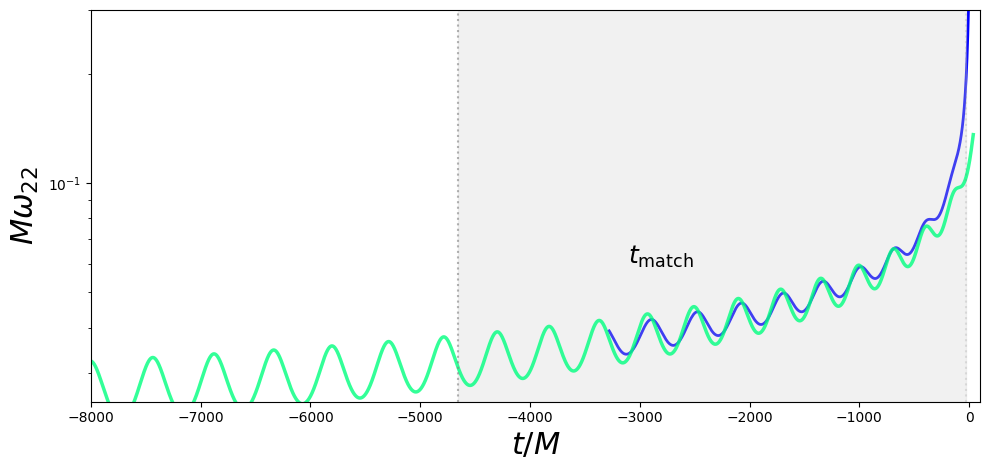

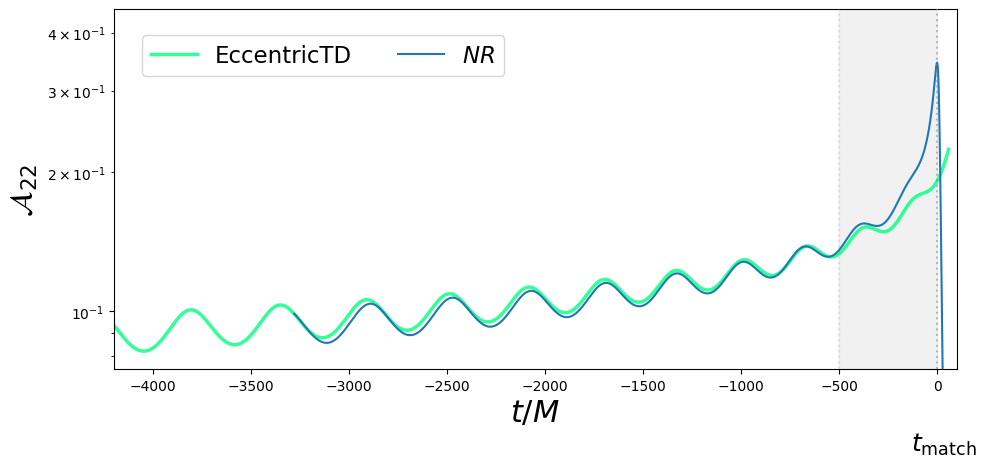

In [47]:
# Don't put frequency in the function argument. It is fixed in the previous block as 0.045. 


#model_22(40,3,0.142,0.665,15.422663198817304,0,1,1/4096)   # used 1371 hyb (Used in paper)

#model_22(30,2,0.12,-0.181,20.5602069553202,0,1,1/4096)  # used 1364 hyb




# with tEcc-350 in frequency plot (new data from package) - gives better freq, worse amplitude
#model_22(30,2,0.0962651881479035,-0.181,20.5602069553202,0,1,1/4096) 



# with tEcc-10 in amplitude (new data from package - gives good PN-NR results - check "Updated PN-NR notebook")
#model_22(30,2,0.125309965337235,-0.181,20.5602069553202,0,1,1/4096) 



# with tEcc+20 in amplitude (another data from package) - gives better amplitude, worse freq
#model_22(30,2,0.114443958375381,-0.181,20.5600048775768,0,1,1/4096) 